<a href="https://colab.research.google.com/github/Anelis17/solar_predict/blob/main/solar_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#기본설정
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xgboost as xgb


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
#데이터 불러오기

energy = pd.read_csv('data/energy.csv') #태양광 발전소 실제 발전량
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv') #당진의 예보데이터
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv') #울산의 예보데이터

In [3]:
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0


In [4]:
#데이터 전처리 및 훈련데이터세트 구성

def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour','Temperature','Humidity','WindSpeed','WindDirection','Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target]
    train_y = train_y.fillna(0).to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target]
    val_y = val_y.fillna(0).to_numpy()
    
    return train_x, train_y, val_x, val_y

In [5]:
#datetime으로 변경 (년, 월, 일, 시, 분, 초 분할)
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])#예보 시간 열의 데이터 타입을 datetime으로 변경
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14] #14시에 예보된 데이터만 사용
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)] #예보시간 기준 3시간 간격의 다음날 예보데이터 사용(다음날 00시 ~ 다음날 23시)

ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date) #예보시간(14시)에  forecast를 더하여 예보시간을 구함
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [6]:
dangjin_fcst_14

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,-2.0,55.0,6.7,336.0,1.0,2018-03-02 00:00:00
23,2018-03-01 14:00:00,13.0,-4.0,55.0,5.5,339.0,1.0,2018-03-02 03:00:00
24,2018-03-01 14:00:00,16.0,-5.0,60.0,4.3,344.0,1.0,2018-03-02 06:00:00
25,2018-03-01 14:00:00,19.0,-2.0,55.0,2.0,345.0,1.0,2018-03-02 09:00:00
26,2018-03-01 14:00:00,22.0,1.0,45.0,0.8,256.0,1.0,2018-03-02 12:00:00
...,...,...,...,...,...,...,...,...
162085,2021-02-28 14:00:00,19.0,8.0,90.0,3.9,64.0,4.0,2021-03-01 09:00:00
162086,2021-02-28 14:00:00,22.0,10.0,90.0,4.8,7.0,4.0,2021-03-01 12:00:00
162087,2021-02-28 14:00:00,25.0,10.0,85.0,6.6,11.0,4.0,2021-03-01 15:00:00
162088,2021-02-28 14:00:00,28.0,7.0,85.0,6.5,34.0,4.0,2021-03-01 18:00:00


In [7]:
#기상예보는 3시간간격으로 되어있지만, 1시간간격으로 태양관 발전량예측을 하기위해
#선형보간법을 이용헤 빈 데이터를 채우기로함

dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

#한시간 간격의 데이터프레임 생성
dangjin_fcst_14_ = pd.DataFrame() 
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

#원본데이터와 합침 
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [8]:
dangjin_fcst_14_ #중간값들이 비어있는 것을 확인가능

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN
26300,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [9]:
#Pandas에서 지원하는 interpolate함수를 이용해 선형보간을 하여 빈 데이터를 채움
dangjin_fcst = dangjin_fcst_14_.interpolate() 
ulsan_fcst = ulsan_fcst_14_.interpolate()

dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [10]:
dangjin_fcst #한시간간격으로 예보데이터가 생성된것을 확인가능

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0


In [11]:
params = { #파라미터 설정
   'learning_rate': 0.01,
     'eval_metric' : 'mae',
    'seed':42
}

In [12]:
def nmae(answer, pred): #학습모델 평가용 Normalized mean error 함수 정의, 원본데이터값의 차이
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [13]:
#당진 수상태양광 발전소의 예측모델 학습
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')

train_dataset = xgb.DMatrix(train_x, train_y)
val_dataset = xgb.DMatrix(val_x, val_y)
eval_sets = [(train_dataset, 'train'), (val_dataset, 'eval')]
capacity = 1000 #발전소의 발전용량
dangjin_floating_model = xgb.train(params, dtrain = train_dataset, evals=eval_sets, early_stopping_rounds=200, verbose_eval=500, num_boost_round = 400 )

[0]	train-mae:121.847	eval-mae:81.8778
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 200 rounds.
[399]	train-mae:33.6764	eval-mae:35.6478


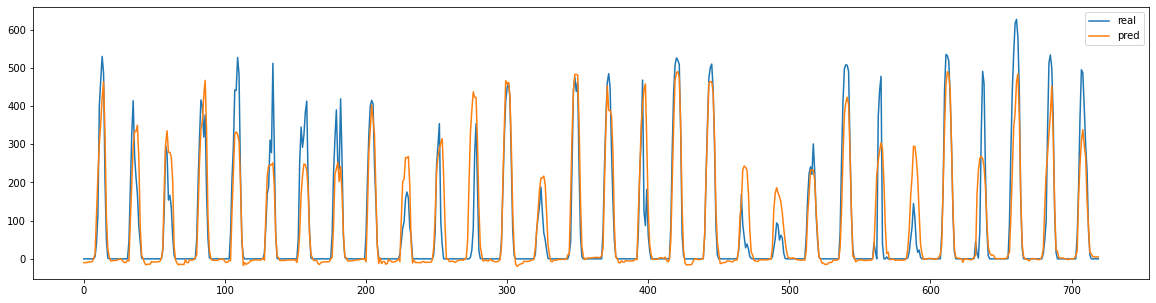

평균 오차 :  8.083446340849907 %


In [14]:
pred = dangjin_floating_model.predict(val_dataset)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='real')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('평균 오차 : ', nmae(val_y, pred),'%')

In [15]:
#충남당진화력본부 자재창고 태양광발전소 예측모델 학습
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = xgb.DMatrix(train_x, train_y)
val_dataset = xgb.DMatrix(val_x, val_y)
capacity = 700
dangjin_warehouse_model = xgb.train(params, dtrain = train_dataset,  evals=eval_sets, early_stopping_rounds=200, verbose_eval=500, num_boost_round = 400 )

[0]	train-mae:122.131	eval-mae:82.0651
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 200 rounds.
[399]	train-mae:48.3378	eval-mae:39.3579


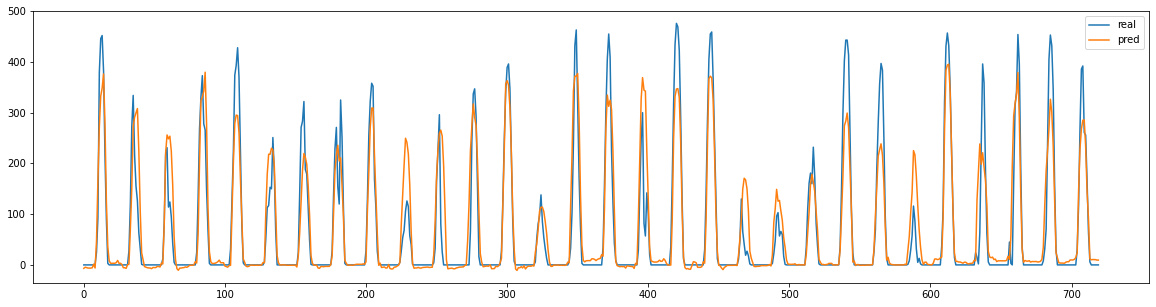

평균 오차 :  9.695795527385178 %


In [16]:
pred = dangjin_warehouse_model.predict(val_dataset)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='real')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('평균 오차 : ', nmae(val_y, pred),'%')

In [17]:
#당진 태양광발전소 예측모델 학습
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = xgb.DMatrix(train_x, train_y)
val_dataset = xgb.DMatrix(val_x, val_y)
capacity = 1000
dangjin_model = xgb.train(params, dtrain = train_dataset,  evals=eval_sets, early_stopping_rounds=200, verbose_eval=500, num_boost_round = 400 )

[0]	train-mae:121.674	eval-mae:81.7029
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[153]	train-mae:41.5546	eval-mae:35.0125



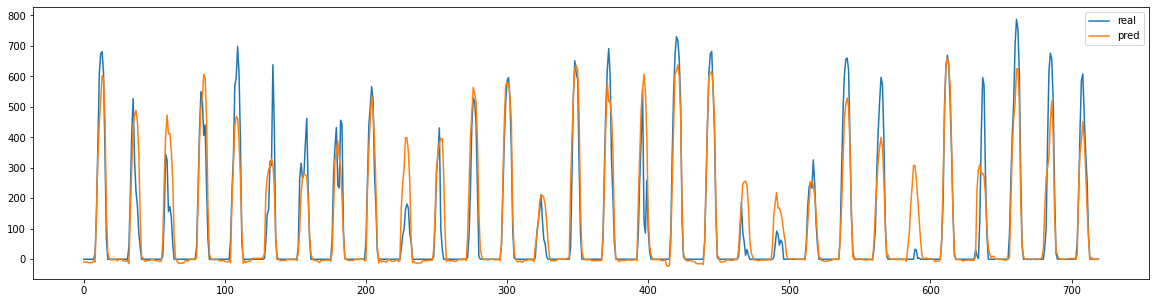

평균 오차 :  9.739438894893345 %


In [18]:
pred = dangjin_model.predict(val_dataset)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='real')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('평균 오차 : ', nmae(val_y, pred),'%')

In [19]:
#울산 태양광발전소 예측모델 학습
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='ulsan')
train_dataset = xgb.DMatrix(train_x, train_y)
val_dataset = xgb.DMatrix(val_x, val_y)
capacity = 1000
ulsan_model = xgb.train(params, dtrain = train_dataset,  evals=eval_sets, early_stopping_rounds=200, verbose_eval=500, num_boost_round = 400 )

[0]	train-mae:122.407	eval-mae:82.2792
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 200 rounds.
[399]	train-mae:70.2294	eval-mae:44.4185


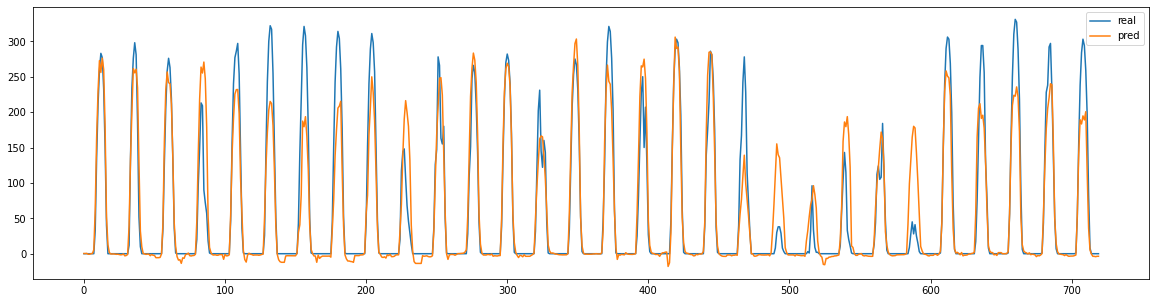

평균 오차 :  4.826292119549879 %


In [20]:
pred = ulsan_model.predict(val_dataset)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='real')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('평균 오차 : ', nmae(val_y, pred),'%')

In [21]:
#2021년 2월의 데이터로 테스트 데이터셋을 만들어 발전소데이터를 추론
def test_datast(fcst_df): 
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()

    
    return test_x

In [22]:
d_test_x = test_datast(dangjin_fcst)
u_test_x = test_datast(ulsan_fcst)

dangjin_test = xgb.DMatrix(d_test_x)
ulsan_test = xgb.DMatrix(u_test_x)

dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

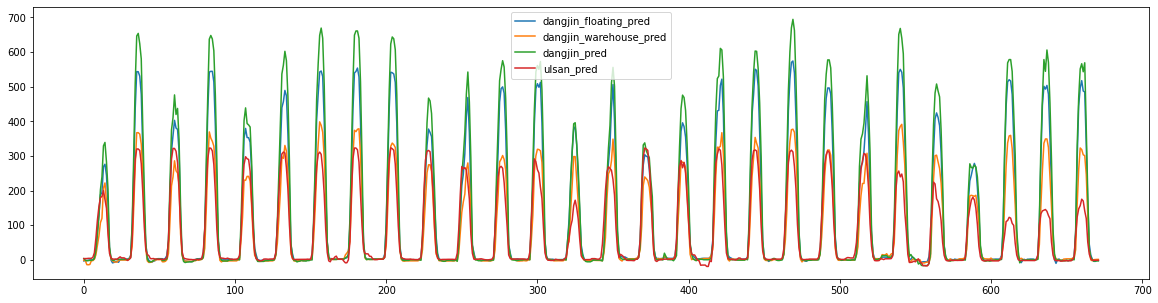

In [23]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()